#### In this file we have performed our initial analysis on our data
        -  Pre-Processing
        -  Nature of data : Unbalanced classes
        -  Frequency of words, WordCloud
        -  Feature importance : Top 30 words in the  classificaiton of Single class
        -  We have also tried Multi Label Classification using one hot encoding of the targets - not good results
        -  Named Entity Recognition using "Clinical-AI-Apollo/Medical-NER" Transformer model
        -  Calculated the presence/absence of entities in processed text and taken as input features to the model.
        -  With these new features implemented classification models

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
import xml.etree.ElementTree as ET
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

### Reading input XML files

In [3]:
# Function to read and extract data from XML files
def extract_data_from_xml(folder_path):
    # Initialize a list to store patient records and annotations
    data = []

    # List files in the folder
    files = os.listdir(folder_path)

    # Iterate over each XML file
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        #print(f"Processing XML file: {file_name}")

        # Parse the XML file
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Extract text content from the TEXT element
        text_content = root.find('.//TEXT').text.strip()

        # Create a dictionary to store the patient record
        record = {"text": text_content}

        # Loop through each TAG element
        for tag in root.findall('.//TAGS/*'):
            attribute = tag.tag
            value = tag.attrib.get('met', None)  # Check if 'met' attribute exists
            record[attribute] = value

        # Append the record to the list of data
        data.append(record)

    # Create a DataFrame from the extracted data
    df = pd.DataFrame(data)

    return df

# Mount Google Drive
#drive.mount('/content/drive')

# Path to the folder containing the XML files
folder_path = r'C:\Users\aslam\Downloads\train\train'

# Extract data from XML files and create a DataFrame
data_df = extract_data_from_xml(folder_path)

In [4]:
data_df.head()

,text,ABDOMINAL,ADVANCED-CAD,ALCOHOL-ABUSE,ASP-FOR-MI,CREATININE,DIETSUPP-2MOS,DRUG-ABUSE,ENGLISH,HBA1C,KETO-1YR,MAJOR-DIABETES,MAKES-DECISIONS,MI-6MOS
0,Record date: 2106-02-12\n\nCampbell Orthopedic...,not met,met,not met,met,not met,met,not met,met,not met,not met,met,met,met
1,Record date: 2079-05-12\n\n\n\n\n\nMERCY CARE ...,not met,met,not met,met,not met,not met,not met,met,not met,not met,not met,met,not met
2,Record date: 2120-09-19\n\nPersonal Data and O...,met,met,not met,met,not met,not met,not met,met,not met,not met,met,met,not met
3,Record date: 2067-11-24\n\n ...,not met,met,not met,met,not met,not met,not met,met,not met,not met,not met,met,not met
4,Record date: 2094-02-16\n\nJENNIFER BOOKER\n\n...,not met,met,not met,not met,not met,not met,not met,met,met,not met,met,met,met


### Exploratory Data Analysis 

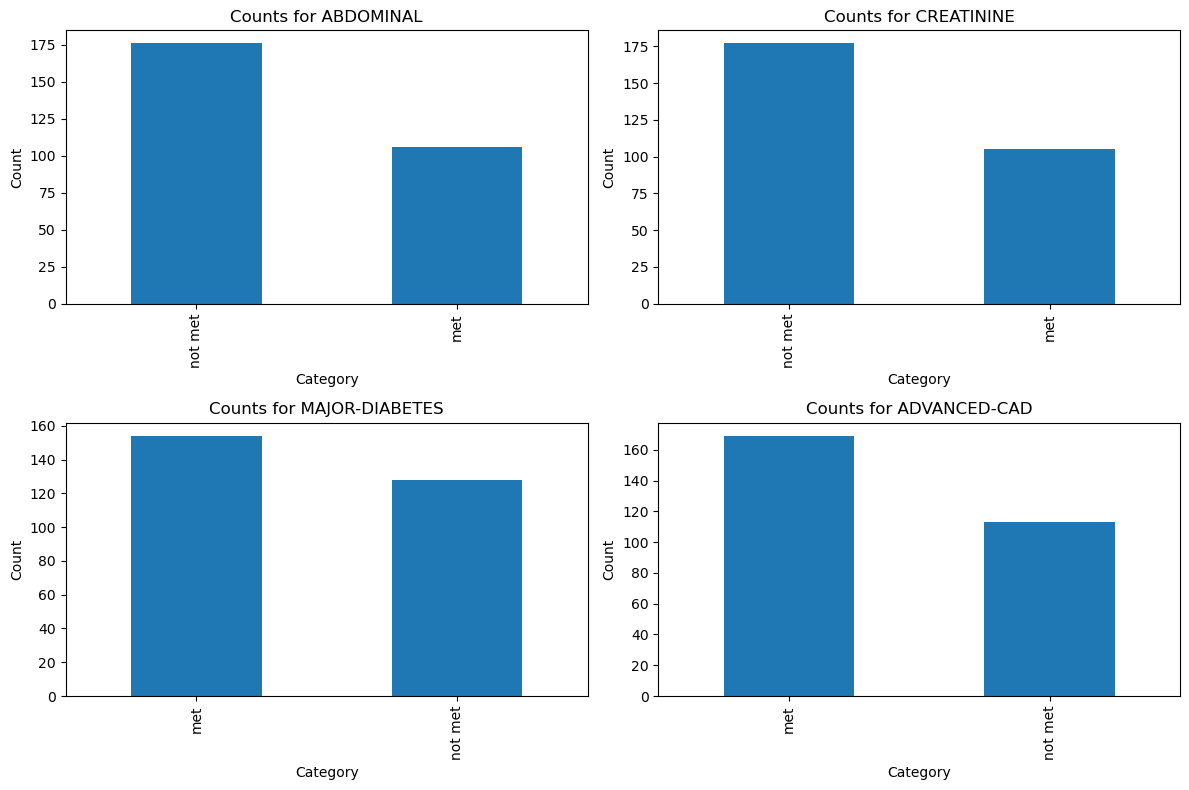

In [5]:
import matplotlib.pyplot as plt

# Define the columns you want to plot
label_cols = ['ABDOMINAL', 'CREATININE', 'MAJOR-DIABETES', 'ADVANCED-CAD']

# Initialize subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each column
for i, column in enumerate(label_cols):
    # Get counts for the current column
    class_counts = data_df[column].value_counts()
    
    # Plot the bar graph
    class_counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Counts for {column}')
    axes[i].set_xlabel('Category')
    axes[i].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()


### Label Encoding 

In [6]:
# Initialize the label encoder
encoder = LabelEncoder()

# Met:0 , Not met :1
for column in data_df.columns:
    # Exclude the column named "Text"
    if column != 'text':
        # Encode the values of the current column
        data_df[column] = encoder.fit_transform(data_df[column])

In [7]:
# List of columns to keep
columns_to_keep = ['text','ABDOMINAL', 'ADVANCED-CAD', 'DIETSUPP-2MOS', 'MAJOR-DIABETES', 'CREATININE']

# Drop columns not in the list
data_df = data_df[columns_to_keep]

### Cleaning 

In [8]:


# Define a function to parse the text and extract relevant information
"""def parse_record(text):
    record = {}

    # Split the text by newline characters to process each line individually
    lines = text.split('\n')

    for line in lines:
        # Split each line by ':' to separate key and value
        parts = line.split(':')

        # If the line has both key and value
        if len(parts) == 2:
            key = parts[0].strip()
            value = parts[1].strip()

            # Add the key-value pair to the record dictionary
            record[key] = value

    return record"""

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    # Join tokens back into a single string
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text

In [9]:
data_df['text'][0]

'Record date: 2106-02-12\n\nCampbell Orthopedic Associates\n4 Madera Circle\nOmak, GA 28172\n \nHabib Valenzuela, M.D.\n \n \n                                             Valdez, Harlan Jr.  \n                                           845-41-54-4\n                                             February 12, 2106 \nHar is a 43 year old 6\' 214 pound gentleman who is referred for\nconsultation by Dr. Harlan Oneil.  About a week ago he slipped on\nthe driveway at home and sustained an injury to his left ankle. \nHe was seen at Tri-City Hospital and was told he had a\nfracture.  He was placed in an air splint and advised to be\npartial weight bearing, and he is using a cane.  He is here for\nroutine follow-up. \nPast medical history is notable for no ankle injuries previously. \nHe has a history of diabetes and sleep apnea.  He takes Prozac,\nCardizem, Glucophage and Amaryl.  He is also followed by Dr. Harold\nNutter for an arrhythmia.  He does not smoke.  He drinks\nminimally.  He is a set 

In [10]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Parse the text data to create a list of dictionaries
#data_df['parsed_text'] = data_df['text'].apply(parse_record)

# Apply preprocessing function to the 'parsed_text' column
data_df['preprocessed_text'] = data_df['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aslam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aslam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aslam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
data_df['preprocessed_text'][0]

'record date 21060212 campbell orthopedic associate 4 madera circle omak ga 28172 habib valenzuela md valdez harlan jr 84541544 february 12 2106 har 43 year old 6 214 pound gentleman referred consultation dr harlan oneil week ago slipped driveway home sustained injury left ankle seen tricity hospital told fracture placed air splint advised partial weight bearing using cane routine followup past medical history notable ankle injury previously history diabetes sleep apnea take prozac cardizem glucophage amaryl also followed dr harold nutter arrhythmia smoke drink minimally set designer columbia picture examination today slight tenderness left ankle four fingerbreadth malleolus malleolus nontender medially laterally ligamentous tenderness either dorsal flexion plantar flexion without pain significant swelling skin change small abrasion proximally fibular tenderness proximally anterior pain noted hindfoot midfoot forefoot tenderness noted would like use tube sock air cast using cane ambula

In [12]:
# Define a function to remove numbers if their length is greater than 3
def remove_long_numbers(text):
    # Define the pattern to match numbers of length greater than 3
    pattern = r'\b\d{4,}\b'
    # Remove the matched numbers
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text
# Apply preprocessing function to the 'parsed_text' column
data_df['preprocessed_text'] = data_df['preprocessed_text'].apply(remove_long_numbers)

In [13]:
data_df.head()

,text,ABDOMINAL,ADVANCED-CAD,DIETSUPP-2MOS,MAJOR-DIABETES,CREATININE,preprocessed_text
0,Record date: 2106-02-12\n\nCampbell Orthopedic...,1,0,0,0,1,record date campbell orthopedic associate 4 m...
1,Record date: 2079-05-12\n\n\n\n\n\nMERCY CARE ...,1,0,1,1,1,record date mercy care center mercy internal ...
2,Record date: 2120-09-19\n\nPersonal Data and O...,0,0,1,0,1,record date personal data overall health pati...
3,Record date: 2067-11-24\n\n ...,1,0,1,1,1,record date huntington emergency dept visit t...
4,Record date: 2094-02-16\n\nJENNIFER BOOKER\n\n...,1,0,1,0,1,record date jennifer booker lc unit nashua m...


### Most Frequent Words

In [14]:
 # Taking only the cad data
cad_criteria = data_df[data_df['ADVANCED-CAD'] == 0]['preprocessed_text']

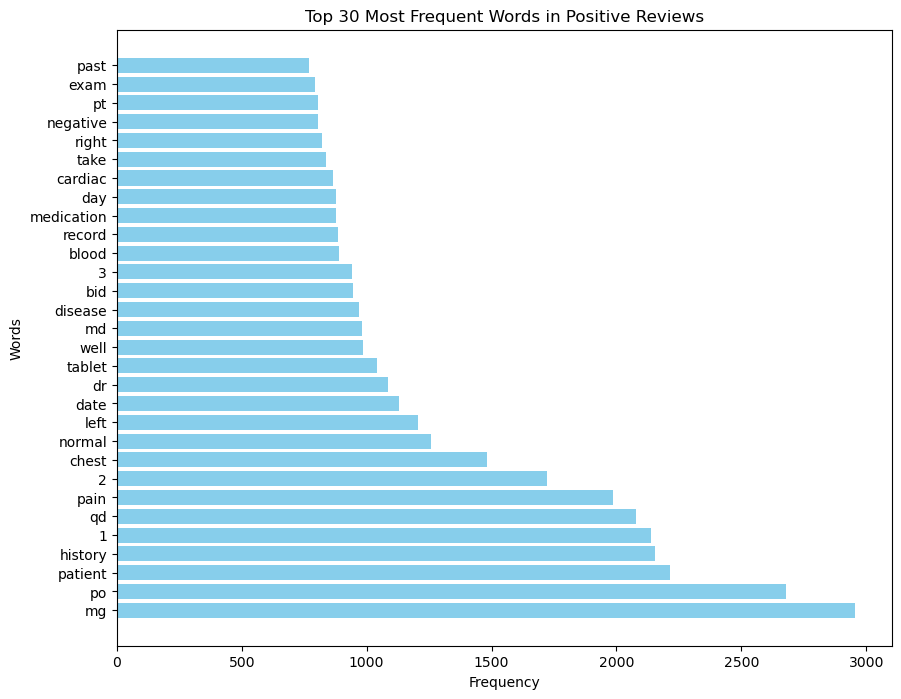

In [15]:
import matplotlib.pyplot as plt
from collections import Counter
# Extract string representations of the WordNetLemmatizer objects
cad_criteria = cad_criteria.apply(lambda x: str(x))
cad_criteria_text = ' '.join(cad_criteria)

# Tokenize
cad_criteria_tokens = cad_criteria_text.split()
# Count the frequency of each word
word_freq = Counter(cad_criteria_tokens)
# Get the top 30 words by frequency
top_words = word_freq.most_common(30)

# Extract words and frequencies
words = [word[0] for word in top_words]
frequencies = [word[1] for word in top_words]
# Plot
plt.figure(figsize=(10, 8))
plt.barh(words, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 30 Most Frequent Words in Positive Reviews')
plt.show()

### Single Label Classification

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier


# Define features and labels
features = data_df['preprocessed_text']
labels = data_df['ADVANCED-CAD']
# Vectorize the tweets
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(features)

# Create a train and test (20%) dataset.
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Define the RandomForestClassifier model
Rf = RandomForestClassifier()

# Train the model
Rf.fit(X_train, y_train)

# Predictions for train data
pred_train = Rf.predict(X_train)

# Predictions for test data
pred_test = Rf.predict(X_test)

In [38]:
def test_train_evaluation_metrics(y_train,y_test,pred_train,pred_test):

    # Generate the confusion matrix, classification report, and accuracy score
    conf_matrix_train= confusion_matrix(y_train, pred_train)
    class_report_train = classification_report(y_train, pred_train)
    accuracy_train= accuracy_score(y_train, pred_train)

    # Print the results for test data
    print("Confusion Matrix for train data:")
    print(conf_matrix_train)
    print("\nClassification Report:")
    print(class_report_train)
    print("\nAccuracy Score:", accuracy_train)


    # Generate the confusion matrix, classification report, and accuracy score
    conf_matrix_test= confusion_matrix(y_test, pred_test)
    class_report_test = classification_report(y_test, pred_test)
    accuracy_test= accuracy_score(y_test, pred_test)

    # Print the results for test data
    print("Confusion Matrix for train data:")
    print(conf_matrix_test)
    print("\nClassification Report:")
    print(class_report_test)
    print("\nAccuracy Score:", accuracy_test)

test_train_evaluation_metrics(y_train,y_test,pred_train,pred_test)

Confusion Matrix for train data:
[[139   0]
 [  0  86]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       139
           1       1.00      1.00      1.00        86

    accuracy                           1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225


Accuracy Score: 1.0
Confusion Matrix for train data:
[[28  2]
 [20  7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.93      0.72        30
           1       0.78      0.26      0.39        27

    accuracy                           0.61        57
   macro avg       0.68      0.60      0.55        57
weighted avg       0.68      0.61      0.56        57


Accuracy Score: 0.6140350877192983


#### Feature Importance

In [39]:
feature_importances = Rf.feature_importances_

# Create a list of feature names
feature_names = vectorizer.get_feature_names_out()

# Sort features and importances together by importance in descending order
feature_importance_pairs = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

# Print the top 10 most important features
print("Top 30 Most Important Features:")
for i in range(30):
    print(f"{feature_importance_pairs[i][0]}: {feature_importance_pairs[i][1]:.4f}")


Top 30 Most Important Features:
cardiac: 0.0238
catheterization: 0.0163
coronary: 0.0103
cad: 0.0092
cath: 0.0066
myocardial: 0.0064
ekg: 0.0061
ischemia: 0.0061
mi: 0.0058
rca: 0.0056
test: 0.0051
temperature: 0.0048
inferior: 0.0047
discomfort: 0.0044
chest: 0.0041
right: 0.0040
ef: 0.0039
ejection: 0.0038
cough: 0.0035
cardiology: 0.0035
allergy: 0.0035
unable: 0.0035
elevated: 0.0034
ntnd: 0.0032
jugular: 0.0031
lv: 0.0030
pain: 0.0030
neurology: 0.0029
s1: 0.0029
apical: 0.0029


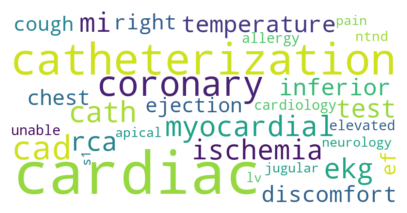

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary of feature importances
word_freq = {pair[0]: pair[1] for pair in feature_importance_pairs[:30]}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_freq)

# Plot word cloud
plt.figure(figsize=(5, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [41]:
from sklearn.svm import SVC

# Initialize the SVM classifier with a polynomial kernel
svm_classifier = SVC(kernel='linear', degree=3)  # You can adjust the degree parameter as needed

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_test = svm_classifier.predict(X_test)
y_pred_train = svm_classifier.predict(X_train)

test_train_evaluation_metrics(y_train,y_test,y_pred_train,y_pred_test)

Confusion Matrix for train data:
[[139   0]
 [  3  83]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       139
           1       1.00      0.97      0.98        86

    accuracy                           0.99       225
   macro avg       0.99      0.98      0.99       225
weighted avg       0.99      0.99      0.99       225


Accuracy Score: 0.9866666666666667
Confusion Matrix for train data:
[[26  4]
 [12 15]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        30
           1       0.79      0.56      0.65        27

    accuracy                           0.72        57
   macro avg       0.74      0.71      0.71        57
weighted avg       0.73      0.72      0.71        57


Accuracy Score: 0.7192982456140351


### Multi label Classification and TFIDF

In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier

# Define label columns
label_cols = ['ABDOMINAL', 'CREATININE', 'MAJOR-DIABETES','ADVANCED-CAD','DIETSUPP-2MOS'] 

# One-hot encode each label column
label_encoders = {}
y_encoded = []
for col in label_cols:
    label_encoder = OneHotEncoder(sparse=False)
    y_col = label_encoder.fit_transform(data_df[col].values.reshape(-1, 1))
    label_encoders[col] = label_encoder
    y_encoded.append(y_col)

# Concatenate encoded labels to form multi-output target
y = np.concatenate(y_encoded, axis=1)

# Feature selection (excluding predicted_entities and preprocessed_text)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data_df['preprocessed_text'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Multi-output classification with MultiOutputClassifier
svm_model = MultiOutputClassifier(SVC(kernel='linear'))  
svm_model.fit(X_train, y_train)

# Predict with the SVM model
y_pred_svm = svm_model.predict(X_test)

# Multi-output classification with MultiOutputClassifier for Random Forest
rf_model = MultiOutputClassifier(RandomForestClassifier())  
rf_model.fit(X_train, y_train)

# Predict with the Random Forest model
y_pred_rf = rf_model.predict(X_test)

# Print classification report for SVM
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Calculate accuracy for SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", accuracy_svm)

# Print classification report for Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Calculate accuracy for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)


C:\Users\aslam\Anaconda3\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\aslam\Anaconda3\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\aslam\Anaconda3\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\aslam\Anaconda3\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in vers

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.09      0.16        23
           1       0.62      1.00      0.76        34
           2       0.78      0.32      0.45        22
           3       0.69      0.94      0.80        35
           4       0.54      0.73      0.62        26
           5       0.68      0.48      0.57        31
           6       0.66      0.90      0.76        30
           7       0.81      0.48      0.60        27
           8       0.68      0.68      0.68        31
           9       0.62      0.62      0.62        26

   micro avg       0.66      0.66      0.66       285
   macro avg       0.71      0.62      0.60       285
weighted avg       0.70      0.66      0.62       285
 samples avg       0.66      0.66      0.66       285

SVM Accuracy: 0.12280701754385964
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.09 

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix
# Convert multilabel format to single-label format by selecting the most probable label
y_pred_rf_single = np.argmax(y_pred_rf, axis=1)
y_test_single = np.argmax(y_test, axis=1)

# Now you can calculate the confusion matrix
rf_cm = confusion_matrix(y_test_single, y_pred_rf_single)
rf_cm

array([[ 2, 21],
       [ 0, 34]], dtype=int64)

### Feature Engineering : NER

In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

model_name = "dmis-lab/biobert-v1.1"  # Choose your model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)


In [ ]:
from transformers import pipeline

def predict_entities_df_pipeline(df, text_column="preprocessed_text"):

    # Create pipeline for clinical NER
    pipe = pipeline("token-classification", model="Clinical-AI-Apollo/Medical-NER", aggregation_strategy='simple')

    # Apply pipeline to each text in the dataframe
    df['predicted_entities'] = df[text_column].apply(lambda x: pipe(x))
    return df

predicted_df_pipeline = predict_entities_df_pipeline(data_df.copy())  
print(predicted_df_pipeline.head()) 


In [ ]:

pd.set_option('display.max_colwidth', None)

predicted_df_pipeline.head()

In [ ]:
import csv
pd.set_option('display.max_colwidth', None)
predicted_df_pipeline.to_csv('NER_names_final.csv', quoting=csv.QUOTE_NONNUMERIC)

In [ ]:
# Save DataFrame to JSON file
predicted_df_pipeline.to_json('NER_names_final.json', orient='records')


In [23]:
#import the above generated entities file
df = pd.read_csv('NER_names_final.csv')
df.head()

,Unnamed: 0,ABDOMINAL,ADVANCED-CAD,ALCOHOL-ABUSE,CREATININE,DRUG-ABUSE,MAJOR-DIABETES,MAKES-DECISIONS,preprocessed_text,predicted_entities
0,0,not met,0,not met,not met,not met,met,met,record date campbell orthopedic associate 4 m...,"[{'entity_group': 'DETAILED_DESCRIPTION', 'sco..."
1,1,not met,0,not met,not met,not met,not met,met,record date mercy care center mercy internal ...,"[{'entity_group': 'DETAILED_DESCRIPTION', 'sco..."
2,2,met,0,not met,not met,not met,met,met,record date personal data overall health pati...,"[{'entity_group': 'LAB_VALUE', 'score': 0.4621..."
3,3,not met,0,not met,not met,not met,not met,met,record date huntington emergency dept visit t...,"[{'entity_group': 'DETAILED_DESCRIPTION', 'sco..."
4,4,not met,0,not met,not met,not met,met,met,record date jennifer booker lc unit nashua m...,"[{'entity_group': 'DETAILED_DESCRIPTION', 'sco..."


In [24]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
encoder = LabelEncoder()

# Define label columns
label_cols = ['ABDOMINAL', 'CREATININE', 'MAJOR-DIABETES','ADVANCED-CAD'] 

# Met:0 , Not met :1
for column in label_cols:
        df[column] = encoder.fit_transform(df[column])


### Calculating Presence(0) and Absense (1) for the entities

<b> From here on we have used features as a combination of vectorized processed text data and Entities presence or absense <b>

In [25]:
import json

# Iterate over each value in the 'predicted_entities' column
for i in range(len(df['predicted_entities'])):
    # Get the JSON string from the DataFrame
    data_str = df['predicted_entities'][i]
    
    # Replace single quotes with double quotes
    data_str = data_str.replace("'", "\"")
    
    # Convert the string into a list of dictionaries
    data_list = json.loads(data_str)
    
    # Update the value in the DataFrame with the list of dictionaries
    df['predicted_entities'][i] = data_list


C:\Users\aslam\AppData\Local\Temp\ipykernel_37668\3842064495.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_entities'][i] = data_list
C:\Users\aslam\AppData\Local\Temp\ipykernel_37668\3842064495.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_entities'][i] = data_list
C:\Users\aslam\AppData\Local\Temp\ipykernel_37668\3842064495.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_ent

C:\Users\aslam\AppData\Local\Temp\ipykernel_37668\3842064495.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_entities'][i] = data_list
C:\Users\aslam\AppData\Local\Temp\ipykernel_37668\3842064495.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_entities'][i] = data_list
C:\Users\aslam\AppData\Local\Temp\ipykernel_37668\3842064495.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_ent

In [26]:

from sklearn.preprocessing import LabelEncoder

# Extract a list of entity types from the predicted_entities column
entity_types = df['predicted_entities'].explode().apply(lambda entity: entity['entity_group']).unique()

# Label encode the entity types
le = LabelEncoder()
entity_types_encoded = le.fit_transform(entity_types)

def create_entity_features(entities):
  """
  This function takes a list of entity dictionaries and returns a feature vector.
  """
  features = np.zeros_like(le.classes_) 
  entity_types = [entity['entity_group'] for entity in entities]
  for entity_type in entity_types:
    # Get the index of the entity type using label encoding
    entity_type_idx = le.transform([entity_type])[0]
    features[entity_type_idx] = 1
  return features

#  le is already fit with unique entity types
df['entity_presence_features'] = df['predicted_entities'].apply(create_entity_features)


In [27]:
len(df['entity_presence_features'][0])

19

In [28]:
# Extract unique entity types
all_entity_types = set()
for entities in df['predicted_entities']:
    if isinstance(entities, list):
        for entity in entities:
            all_entity_types.add(entity.get('entity_group'))
            
all_entity_types

{'AGE',
 'BIOLOGICAL_STRUCTURE',
 'CLINICAL_EVENT',
 'DATE',
 'DETAILED_DESCRIPTION',
 'DIAGNOSTIC_PROCEDURE',
 'DISEASE_DISORDER',
 'DISTANCE',
 'DOSAGE',
 'DURATION',
 'FAMILY_HISTORY',
 'HISTORY',
 'LAB_VALUE',
 'MEDICATION',
 'NONBIOLOGICAL_LOCATION',
 'SEVERITY',
 'SEX',
 'SIGN_SYMPTOM',
 'THERAPEUTIC_PROCEDURE'}

###  Vectorizer : TF IDF

###   Random Forest and SVM:Single label Classification

In [29]:

y_encoded = df['ADVANCED-CAD']

# Feature Engineering - TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
tfidf_features = tfidf_vectorizer.fit_transform(df['preprocessed_text'])
#X_preprocessed_text = vectorizer.fit_transform(df['preprocessed_text'])

# Combine Features
#X = np.hstack((X_preprocessed_text.toarray(), X_named_entity_scores.reshape(-1, 1)))
def convert_to_binary(feature_list):
    return [1 if item else 0 for item in feature_list]

# Convert features to binary format and NumPy array
entity_features_array = np.array(df['entity_presence_features'].apply(convert_to_binary).tolist())

# Convert the binary feature arrays to a sparse matrix
entity_features_sparse = csr_matrix(entity_features_array)


# Option 1: Stack features horizontally
X = hstack((entity_features_sparse, tfidf_features))

# Split data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X,y_encoded , test_size=0.2, random_state=42)

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train SVM Model (optional kernel can be adjusted)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Evaluate Random Forest Model
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_report = classification_report(y_test, y_pred_rf)

# Print Random Forest Results
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:\n", rf_report)

# Evaluate SVM Model
y_pred_svm = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_report = classification_report(y_test, y_pred_svm)

# Print SVM Results
print("SVM Accuracy:", svm_accuracy)
print("SVM Classification Report:\n", svm_report)


Random Forest Accuracy: 0.8048780487804879
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.70      0.58      0.64        12

    accuracy                           0.80        41
   macro avg       0.77      0.74      0.75        41
weighted avg       0.80      0.80      0.80        41

SVM Accuracy: 0.6585365853658537
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.69      0.74        29
           1       0.44      0.58      0.50        12

    accuracy                           0.66        41
   macro avg       0.62      0.64      0.62        41
weighted avg       0.69      0.66      0.67        41



###  Random Forest and SVM :  MultiOutputClassifier

In [30]:
train, test = train_test_split(df, random_state=42, test_size=0.20, shuffle=True)

label_cols = ['ABDOMINAL', 'CREATININE', 'MAJOR-DIABETES','ADVANCED-CAD']

# Use columns argument in drop with set difference
filtered_train = train.drop(columns=list(set(train.columns) - set(label_cols)))

# Use columns argument in drop with set difference
filtered_test = test.drop(columns=list(set(test.columns) - set(label_cols)))

In [31]:


y= df['ADVANCED-CAD']
    
# Feature Engineering - TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
tfidf_features = tfidf_vectorizer.fit_transform(df['preprocessed_text'])


# Combine Features

def convert_to_binary(feature_list):
    return [1 if item else 0 for item in feature_list]

# Convert features to binary format and NumPy array
entity_features_array = np.array(df['entity_presence_features'].apply(convert_to_binary).tolist())

# Convert the binary feature arrays to a sparse matrix
entity_features_sparse = csr_matrix(entity_features_array)

# Option 1: Stack features horizontally
X = hstack((entity_features_sparse, tfidf_features))
#X = np.hstack((df['entity_presence_features'], tfidf_features))  # Combine entity and TF-IDF features
#X1=X[1:]

# Split data into training and testing sets with stratification
X_train, X_test,_, _ = train_test_split(X,y , test_size=0.2, random_state=42)

# Multi-output classification with MultiOutputClassifier
svm_model = MultiOutputClassifier(SVC(kernel='linear'))  
svm_model.fit(X_train, filtered_train)

# Predict with the SVM model
y_pred_svm = svm_model.predict(X_test)

# Multi-output classification with MultiOutputClassifier for Random Forest
rf_model = MultiOutputClassifier(RandomForestClassifier())  
rf_model.fit(X_train, filtered_train)

# Evaluate Random Forest Model
y_pred_rf = rf_model.predict(X_test)
rf_report = classification_report(filtered_test, y_pred_rf)

print("Random Forest Classification Report:\n", rf_report)

# Evaluate SVM Model
y_pred_svm = svm_model.predict(X_test)
svm_report = classification_report(filtered_test, y_pred_svm)

print("SVM Classification Report:\n", svm_report)


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.92      0.75        24
           1       0.64      0.58      0.61        12
           2       0.70      0.96      0.81        24
           3       0.73      0.47      0.57        17

   micro avg       0.67      0.78      0.72        77
   macro avg       0.67      0.73      0.68        77
weighted avg       0.67      0.78      0.71        77
 samples avg       0.60      0.74      0.63        77

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.83      0.73        24
           1       0.44      0.58      0.50        12
           2       0.66      0.88      0.75        24
           3       0.53      0.53      0.53        17

   micro avg       0.59      0.74      0.66        77
   macro avg       0.57      0.71      0.63        77
weighted avg       0.59      0.74      0.66        77
 samples av

C:\Users\aslam\Anaconda3\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aslam\Anaconda3\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aslam\Anaconda3\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###  Random Forest  : BinaryRelevance

In [34]:

# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(RandomForestClassifier(n_jobs=-1))

# train
classifier.fit(X_train, filtered_train)

# predict
predictions = classifier.predict(X_test)

rf_binary = classification_report(filtered_test, predictions)
print(rf_binary)

              precision    recall  f1-score   support

           0       0.58      0.75      0.65        24
           1       0.55      0.50      0.52        12
           2       0.67      0.83      0.74        24
           3       0.50      0.35      0.41        17

   micro avg       0.60      0.65      0.62        77
   macro avg       0.57      0.61      0.58        77
weighted avg       0.58      0.65      0.61        77
 samples avg       0.54      0.64      0.54        77



C:\Users\aslam\Anaconda3\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aslam\Anaconda3\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Convert multilabel format to single-label format by selecting the most probable label
y_pred_rf_single = np.argmax(y_pred_rf, axis=1)
y_test_single = np.argmax(filtered_test, axis=1)

# Now you can calculate the confusion matrix
rf_cm = confusion_matrix(y_test_single, y_pred_rf_single)
rf_cm

array([[25,  2,  0,  0],
       [ 6,  0,  0,  0],
       [ 5,  1,  0,  0],
       [ 2,  0,  0,  0]], dtype=int64)

### Count vectorizer & Random Forest and SVM :  MultiOutputClassifier

In [36]:
# Feature Engineering - 
vectorizer = CountVectorizer()
tfidf_features = vectorizer.fit_transform(df['preprocessed_text'])

# Combine Features

def convert_to_binary(feature_list):
    return [1 if item else 0 for item in feature_list]

# Convert features to binary format and NumPy array
entity_features_array = np.array(df['entity_presence_features'].apply(convert_to_binary).tolist())

# Convert the binary feature arrays to a sparse matrix
entity_features_sparse = csr_matrix(entity_features_array)

# Option 1: Stack features horizontally
X = hstack((entity_features_sparse, tfidf_features))

# Split data into training and testing sets with stratification
X_train, X_test,_,_ = train_test_split(X,y , test_size=0.2, random_state=42)

# Multi-output classification with MultiOutputClassifier
svm_model = MultiOutputClassifier(SVC(kernel='linear'))  
svm_model.fit(X_train, filtered_train)

# Predict with the SVM model
y_pred_svm = svm_model.predict(X_test)

# Multi-output classification with MultiOutputClassifier for Random Forest
rf_model = MultiOutputClassifier(RandomForestClassifier())  
rf_model.fit(X_train, filtered_train)

# Evaluate Random Forest Model
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(filtered_test, y_pred_rf)
rf_report = classification_report(filtered_test, y_pred_rf)

# Print Random Forest Results
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:\n", rf_report)

# Evaluate SVM Model
y_pred_svm = svm_model.predict(X_test)
svm_accuracy = accuracy_score(filtered_test, y_pred_svm)
svm_report = classification_report(filtered_test, y_pred_svm)

# Print SVM Results
print("SVM Accuracy:", svm_accuracy)
print("SVM Classification Report:\n", svm_report)


C:\Users\aslam\Anaconda3\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aslam\Anaconda3\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Accuracy: 0.1951219512195122
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.92      0.73        24
           1       1.00      0.33      0.50        12
           2       0.61      0.92      0.73        24
           3       0.43      0.35      0.39        17

   micro avg       0.60      0.70      0.65        77
   macro avg       0.66      0.63      0.59        77
weighted avg       0.63      0.70      0.62        77
 samples avg       0.55      0.67      0.56        77

SVM Accuracy: 0.24390243902439024
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.88      0.78        24
           1       0.47      0.75      0.58        12
           2       0.70      0.79      0.75        24
           3       0.60      0.88      0.71        17

   micro avg       0.63      0.83      0.72        77
   macro avg       0.62      0.82      0.7

C:\Users\aslam\Anaconda3\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aslam\Anaconda3\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
